In [60]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')
import json
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler
from utils.losses import MSE, MEE
from utils.results import plot_results, output_correlations
from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params

In [61]:
''' FOR THE FIRST TIME
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]

sort_idx = np.argsort(raw_data[:,11]) ; raw_data = raw_data[sort_idx]
np.random.shuffle(raw_data)
input_data=raw_data[:,:-2]
input_labels=raw_data[:,-2:]

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)
Test_dataset = np.column_stack((test_set,test_labels))
Data_dataset = np.column_stack((data,labels))
np.savetxt('../../data/Test_set.txt',Test_dataset) ; np.savetxt('../../data/Data_set.txt',Data_dataset)
'''
raw_data = np.loadtxt("../../data/Data_set.txt")
data_scaler = StandardScaler() ; labels_scaler = StandardScaler(kind = 'vector')
raw_data[:,:-2] = data_scaler.fit_transform(raw_data[:,:-2]) 
raw_data[:,-2:] = labels_scaler.fit_transform(raw_data[:,-2:])

#splitting the data from the labels
data=raw_data[:,:-2]
labels=raw_data[:,-2:]

In [62]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

In [58]:
list_lamb = np.logspace(-7,-5,5)  ; print(list_lamb)

[1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05]


In [59]:
import utils.grid_search
importlib.reload(utils.grid_search)
from utils.grid_search import grid_search

# Structure to test: 
n_feat = np.shape(labels)[1]

#model1 = {'structure': [10, n_feat],   'func':['sigmoid','linear'], 'starting_points': xavier([10, n_feat])}
#model1 = {'structure': [20,n_feat] ,   'func':['sigmoid','linear'], 'starting_points': xavier ([10, n_feat])}
model1 = {'structure': [5,5,n_feat],   'func':['tanh','relu','linear'],'starting_points': xavier([5,5,n_feat])}
model2 = {'structure': [10,5, n_feat], 'func':['tanh','relu','linear'],'starting_points': xavier([10,5, n_feat])}
#model5= {'structure': [10,5,n_feat],'func':['tanh','tanh','linear'],'starting_points': xavier([10,5,n_feat])}
#model6= {'structure': [10,10,n_feat],'func':['tanh','tanh','linear'],'starting_points': xavier([10,10,n_feat])}

models = [model1,model2]
dict_models = {f'Model{i}': m for i, m in enumerate(models)} 

list_eta = [1e-4]
list_alpha = np.arange(0.1,0.3,0.1)
list_lamb =  np.logspace(-7,-5,3) ; list_beta = np.arange(0.75,0.85,0.05)
dict_params = {'eta':list_eta, 'alpha':list_alpha, 'lamb':list_lamb, 'epoch':[10000], 
                'RMSProp' : [True], 'nesterov' : [True] , 'beta' : list_beta , 'verbose' : [True],
                'batch_size' : [-1,32],'error_threshold' : [0] ,'patience' : [200], 'n_candidate' : [3]
                'test_more_init': [True]}

grid_results = grid_search(MLP_w, dict_models, dict_params, 
                           data, labels, MEE, n_jobs = 3,
                           verbose = False, kind = 'k_fold', k = 4)

SyntaxError: invalid syntax (1718812384.py, line 24)

In [ ]:
grid_results[0]
#np.savetxt('../../data/sigmoid_search.txt',grid_results[1:10])

{'train': {'eta': 8e-05,
  'alpha': 0.2,
  'lamb': 1e-06,
  'epoch': 10000,
  'RMSProp': True,
  'nesterov': True,
  'beta': 0.7,
  'verbose': True,
  'batch_size': 32,
  'error_threshold': 0,
  'patience': 400},
 'model': {'structure': [20, 2],
  'func': ['sigmoid', 'linear'],
  'starting_points': [0.5477225575051661, 0.5222329678670935]},
 'model_name': 'Model0',
 'Error': 0.2829808470599667}

In [ ]:

#Comment after the grid search is ended, and change file name or will overwrite it
import json

with open('../report/json/sigmoid_search.json','w') as fp:
    json.dump(grid_results,fp) 


In [63]:
import json
#loading dictionary grid_search
with open('../report/json/all_dict.json') as json_file:
    grid_results = json.load(json_file)

In [65]:
frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)
best_model_dict = grid_results[0] ; best_model_dict['patience'] = 300
best_model_dict['model']
best_model = MLP_w(**best_model_dict['model'])
train_dict = dict(best_model_dict['train'])
train_dict['n_candidate'] = 5
train_dict['test_more_init']

True

In [66]:
best_model.train(input_data, train_labels, val_data, val_labels, **train_dict)
best_model_dict['patience']

Candidate 0
Epoch 4287:  [train MEE = 0.1421]  [val MEE = 0.1650]                              
Elapsed time: 36.32801294326782 s
Candidate 1
Epoch 2398:  [train MEE = 0.1457]  [val MEE = 0.1660]                              
Elapsed time: 19.029555320739746 s
Candidate 2
Epoch 2136:  [train MEE = 0.1493]  [val MEE = 0.1683]                              
Elapsed time: 17.724458932876587 s
Candidate 3
Epoch 3015:  [train MEE = 0.1417]  [val MEE = 0.1638]                              
Elapsed time: 23.96311926841736 s
Candidate 4
Epoch 5137:  [train MEE = 0.1356]  [val MEE = 0.1620]                              
Elapsed time: 43.42630648612976 s


300

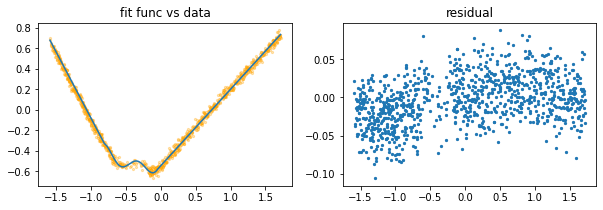

RMS = 1.0055655494609597 (root sum of squared residual)


'kmax iteration reached'

In [67]:
other_output= train_labels[:,0]
lin_output= train_labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((input_data,train_labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'vecstd')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

fig, axs = plt.subplots(1, 2, figsize = (10, 3))
axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
axs[0].set_title('fit func vs data')
axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
axs[1].set_title('residual')
plt.show()
RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2)) ; print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

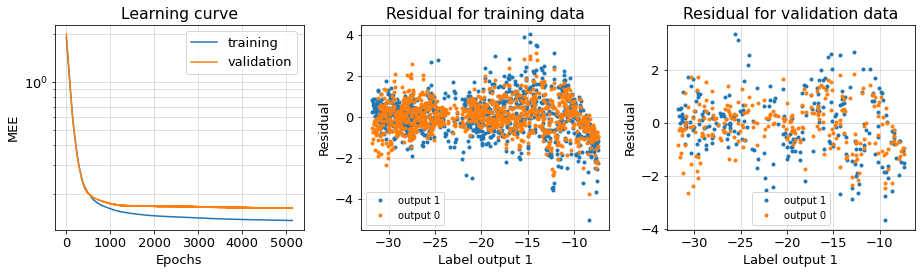

final train error: 0.9999258645725899
final val error: 1.1948454347022301


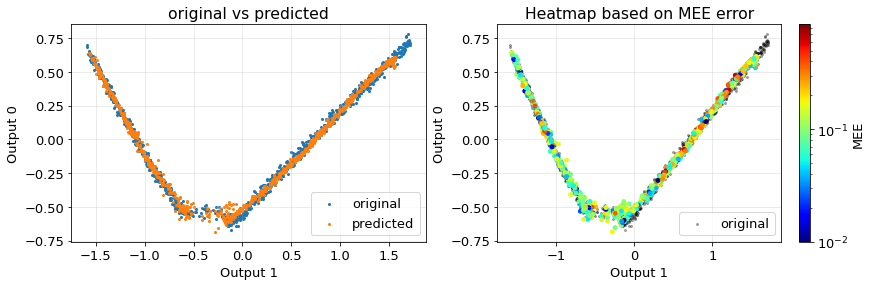

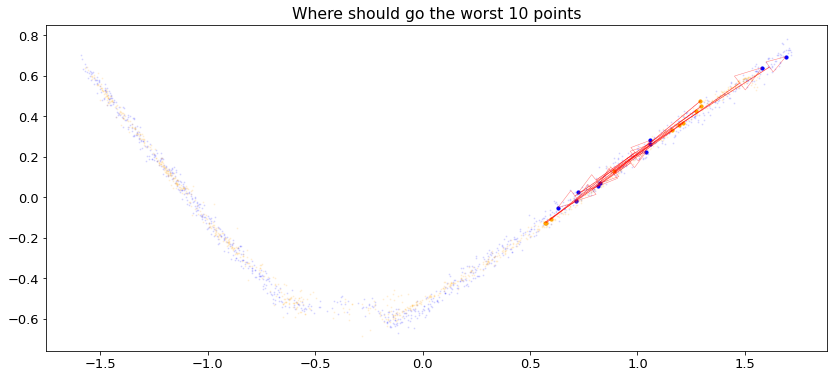

array([101,  67, 118, 917,   8, 755, 844, 623, 557, 722])

In [68]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

plot_results(best_model, input_data, val_data, train_labels, val_labels, sortidx = 1,
                 norm = labels_scaler.inverse_transform, mean_fit = False,savefig = True,
                 filename = 'without_fit')
pred = best_model.predict(data)
#func = lin_sin_lin,func_args= popt_sin

output_correlations(best_model, input_data, train_labels, plot_arrow_worse = 10)


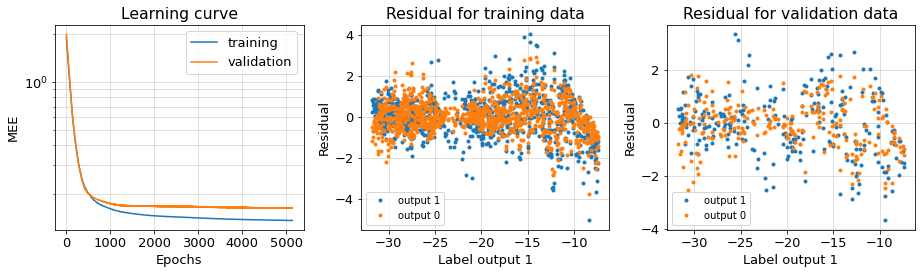

final train error: 0.9908617275047339
final val error: 1.1797060127511612


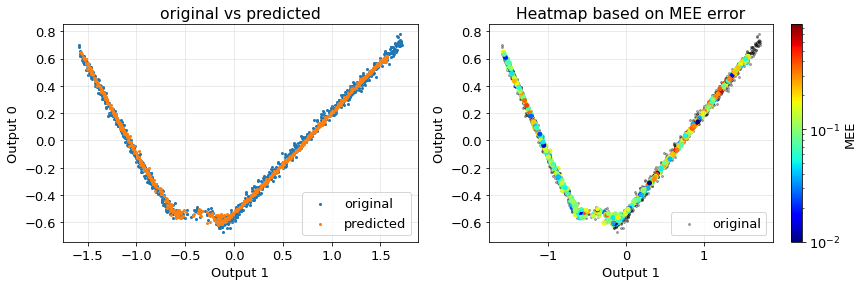

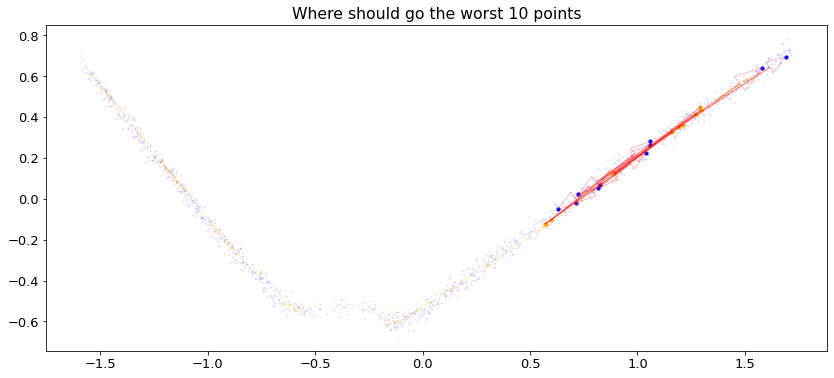

'\npred = best_model.predict(data)\n\nplt.xlabel(\'output 1\') ; plt.ylabel(\'output 2\')\nplt.plot(labels[:,1],labels[:,0],".")\nplt.plot(pred[:,1],pred[:,0],".")'

In [69]:
plot_results(best_model, input_data, val_data, train_labels, val_labels, sortidx = 1,
                 norm = labels_scaler.inverse_transform, mean_fit = True,func = lin_sin_lin,func_args= popt_sin
                ,savefig = True, filename = 'fit_best')

output_correlations(best_model, input_data, train_labels, plot_arrow_worse = 10,
                    fit_func = lin_sin_lin, func_args = popt_sin)


'''
pred = best_model.predict(data)

plt.xlabel('output 1') ; plt.ylabel('output 2')
plt.plot(labels[:,1],labels[:,0],".")
plt.plot(pred[:,1],pred[:,0],".")'''